## Лабораторная работа №2
### Линейная нейронная сеть. Правило обучения Уидроу-Хоффа
#### *Прудникова Анастасия М8О-408Б-20*
*Вариант 24*

*Целью работы* является исследование свойств линейной нейронной сети и алгоритмов её обучения, применение сети в задачах аппроксимации и фильтрации.

**Основные этапы работы:**
1. Использовать линейную нейронную сеть с задержками для аппроксимации функции. В качестве метода обучения использовать адаптацию.
2. Использовать линейную нейронную сеть с задержками для аппроксимации функции и выполнения многошагового прогноза.
3. Использовать линейную нейронную сеть в качестве адаптивного фильтра для подавления помех. Для настройки весовых коэффициентов использовать метод наименьших квадратов.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [15]:
def x(t: float):
    return np.cos(0.5 * t ** 2 - 5 * t)

D = 5  
t = np.arange(0, 2, 0.01) 
X = x(t).tolist()          
sequences = [X[i:i+D] for i in range(0, len(X) - D)]   
upcoming_points = [X[i] for i in range(D, len(X))]   

assert len(sequences) == len(upcoming_points)

In [16]:
def sync_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [17]:
x_train, y_train = sync_shuffle(np.array(sequences), np.array(upcoming_points))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

In [18]:
class ADALINE(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

Нейросеть принимает на вход D дискрет и имеет один выходной нейрон - нпоследущую дискрету.

В качестве функции потерь берем nn.MSELoss()

In [19]:
adaline = ADALINE(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaline.parameters(), lr=0.05)

In [20]:
def fit(model, x_train, y_train, criterion, optimizer, epochs):
    losses = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            optimizer.zero_grad()
            outp = model(x_train)

            loss = criterion(outp.view(-1), y_train)

            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

In [21]:
# Предсказание
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

In [22]:
# Обучение
losses = fit(adaline, x_train, y_train, loss_function, optimizer, 50)

epoch:  70%|███████   | 35/50 [00:00<00:00, 154.56it/s]


Epoch 001 train_loss: 7.7692

Epoch 002 train_loss: 5.2986

Epoch 003 train_loss: 3.7483

Epoch 004 train_loss: 2.7426

Epoch 005 train_loss: 2.0660

Epoch 006 train_loss: 1.5937

Epoch 007 train_loss: 1.2523

Epoch 008 train_loss: 0.9976

Epoch 009 train_loss: 0.8028

Epoch 010 train_loss: 0.6507

Epoch 011 train_loss: 0.5301

Epoch 012 train_loss: 0.4334

Epoch 013 train_loss: 0.3551

Epoch 014 train_loss: 0.2915

Epoch 015 train_loss: 0.2396

Epoch 016 train_loss: 0.1971

Epoch 017 train_loss: 0.1622

Epoch 018 train_loss: 0.1335

Epoch 019 train_loss: 0.1100

Epoch 020 train_loss: 0.0906

Epoch 021 train_loss: 0.0747

Epoch 022 train_loss: 0.0615

Epoch 023 train_loss: 0.0507

Epoch 024 train_loss: 0.0418

Epoch 025 train_loss: 0.0345

Epoch 026 train_loss: 0.0285

Epoch 027 train_loss: 0.0235

Epoch 028 train_loss: 0.0194

Epoch 029 train_loss: 0.0160

Epoch 030 train_loss: 0.0132

Epoch 031 train_loss: 0.0110

Epoch 032 train_loss: 0.0091

Epoch 033 train_loss: 0.0075

Epoch 034

epoch: 100%|██████████| 50/50 [00:00<00:00, 162.51it/s]


Epoch 036 train_loss: 0.0043

Epoch 037 train_loss: 0.0036

Epoch 038 train_loss: 0.0030

Epoch 039 train_loss: 0.0025

Epoch 040 train_loss: 0.0021

Epoch 041 train_loss: 0.0018

Epoch 042 train_loss: 0.0015

Epoch 043 train_loss: 0.0013

Epoch 044 train_loss: 0.0011

Epoch 045 train_loss: 0.0010

Epoch 046 train_loss: 0.0008

Epoch 047 train_loss: 0.0007

Epoch 048 train_loss: 0.0007

Epoch 049 train_loss: 0.0006

Epoch 050 train_loss: 0.0005


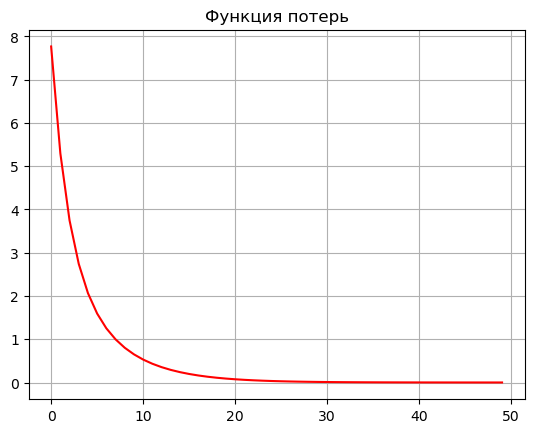

In [24]:
plt.plot(losses, color='red')
plt.grid(True, which='both')
plt.title('Функция потерь')
plt.show()

In [25]:
# Вычислим отклонения от настоящих значений
X_PRED = X[:D]
errors = []

for i in range(0, len(upcoming_points)):
    x_test = torch.FloatTensor(np.array(sequences[i]))
    upcoming_point_pred = predict(adaline, x_test)
    X_PRED += upcoming_point_pred.numpy().tolist()
    errors += (upcoming_point_pred - upcoming_points[i]).numpy().tolist()

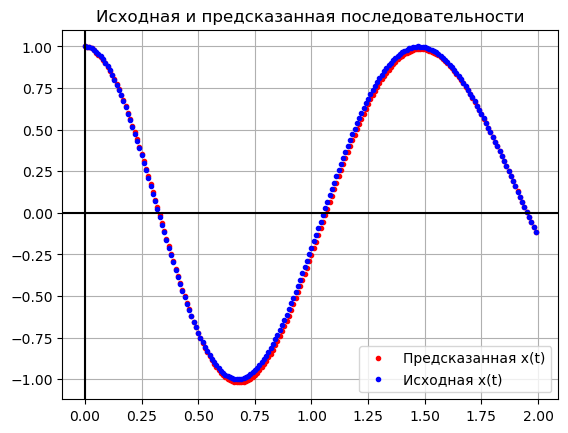

In [26]:
plt.plot(t, X_PRED, '.', color="red", label='Предсказанная x(t)')
plt.plot(t, X, '.', color="blue", label='Исходная x(t)')
plt.title('Исходная и предсказанная последовательности')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

Как можно увидеть из графика, отклонение небольшое.

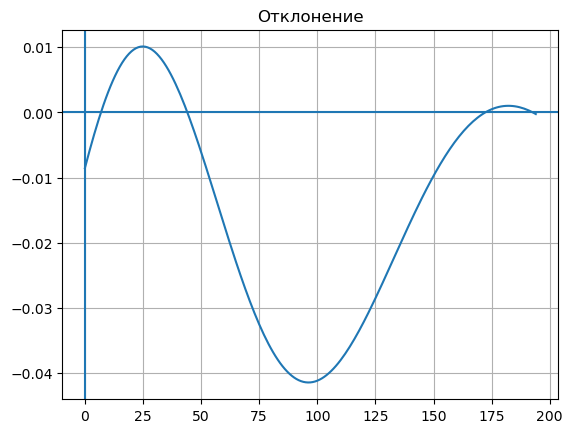

In [29]:
plt.plot(errors)
plt.grid(True, which='both')
plt.axhline(y=0)
plt.axvline(x=0)
plt.title('Отклонение')

plt.show()

In [56]:
def true_signal(t):
    return np.sin(t ** 2 - 2 * t + 5)


def noized_signal(t):
    return ((1 / 7) * np.sin(t ** 2 - 2 * t + np.pi))


D = 4 
t = np.arange(0, 5, 0.025)   
X = true_signal(t).tolist() 
Y = noized_signal(t).tolist()  

noized_sequences = [Y[i:i+D] for i in range(0, len(Y) - D)] 
upcoming_points_true = [X[i] for i in range(D, len(X))]   

assert len(noized_sequences) == len(upcoming_points_true)

In [57]:
x_train, y_train = sync_shuffle(np.array(noized_sequences), np.array(upcoming_points_true))

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)


In [58]:
adaline2 = ADALINE(D, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(adaline2.parameters(), lr=0.05)

In [59]:
losses2 = fit(adaline2, x_train, y_train, loss_function, optimizer, 600)

epoch:   6%|▌         | 35/600 [00:00<00:02, 217.62it/s]


Epoch 001 train_loss: 2.8916

Epoch 002 train_loss: 2.4677

Epoch 003 train_loss: 2.1240

Epoch 004 train_loss: 1.8451

Epoch 005 train_loss: 1.6188

Epoch 006 train_loss: 1.4350

Epoch 007 train_loss: 1.2856

Epoch 008 train_loss: 1.1642

Epoch 009 train_loss: 1.0653

Epoch 010 train_loss: 0.9848

Epoch 011 train_loss: 0.9190

Epoch 012 train_loss: 0.8653

Epoch 013 train_loss: 0.8212

Epoch 014 train_loss: 0.7850

Epoch 015 train_loss: 0.7553

Epoch 016 train_loss: 0.7306

Epoch 017 train_loss: 0.7102

Epoch 018 train_loss: 0.6931

Epoch 019 train_loss: 0.6788

Epoch 020 train_loss: 0.6668

Epoch 021 train_loss: 0.6565

Epoch 022 train_loss: 0.6477

Epoch 023 train_loss: 0.6401

Epoch 024 train_loss: 0.6335

Epoch 025 train_loss: 0.6277

Epoch 026 train_loss: 0.6225

Epoch 027 train_loss: 0.6178

Epoch 028 train_loss: 0.6136

Epoch 029 train_loss: 0.6097

Epoch 030 train_loss: 0.6060

Epoch 031 train_loss: 0.6027

Epoch 032 train_loss: 0.5995

Epoch 033 train_loss: 0.5964

Epoch 034


Epoch 036 train_loss: 0.5881

Epoch 037 train_loss: 0.5854

Epoch 038 train_loss: 0.5829

Epoch 039 train_loss: 0.5804

Epoch 040 train_loss: 0.5779

Epoch 041 train_loss: 0.5755

Epoch 042 train_loss: 0.5732

Epoch 043 train_loss: 0.5708

Epoch 044 train_loss: 0.5685

Epoch 045 train_loss: 0.5663

Epoch 046 train_loss: 0.5640

Epoch 047 train_loss: 0.5618

Epoch 048 train_loss: 0.5596

Epoch 049 train_loss: 0.5574

Epoch 050 train_loss: 0.5552

Epoch 051 train_loss: 0.5531

Epoch 052 train_loss: 0.5509

Epoch 053 train_loss: 0.5488

Epoch 054 train_loss: 0.5467

Epoch 055 train_loss: 0.5446

Epoch 056 train_loss: 0.5426

Epoch 057 train_loss: 0.5405

Epoch 058 train_loss: 0.5385

Epoch 059 train_loss: 0.5365

Epoch 060 train_loss: 0.5345

Epoch 061 train_loss: 0.5325

Epoch 062 train_loss: 0.5305

Epoch 063 train_loss: 0.5285

Epoch 064 train_loss: 0.5266

Epoch 065 train_loss: 0.5246

Epoch 066 train_loss: 0.5227

Epoch 067 train_loss: 0.5208

Epoch 068 train_loss: 0.5189

Epoch 069


Epoch 077 train_loss: 0.5025

Epoch 078 train_loss: 0.5007

Epoch 079 train_loss: 0.4989

Epoch 080 train_loss: 0.4972

Epoch 081 train_loss: 0.4955

Epoch 082 train_loss: 0.4937

Epoch 083 train_loss: 0.4920

Epoch 084 train_loss: 0.4904

Epoch 085 train_loss: 0.4887

Epoch 086 train_loss: 0.4870

Epoch 087 train_loss: 0.4853

Epoch 088 train_loss: 0.4837

Epoch 089 train_loss: 0.4821

Epoch 090 train_loss: 0.4804

Epoch 091 train_loss: 0.4788

Epoch 092 train_loss: 0.4772

Epoch 093 train_loss: 0.4756

Epoch 094 train_loss: 0.4741

Epoch 095 train_loss: 0.4725

Epoch 096 train_loss: 0.4709

Epoch 097 train_loss: 0.4694

Epoch 098 train_loss: 0.4679

Epoch 099 train_loss: 0.4663

Epoch 100 train_loss: 0.4648

Epoch 101 train_loss: 0.4633

Epoch 102 train_loss: 0.4618

Epoch 103 train_loss: 0.4604

Epoch 104 train_loss: 0.4589

Epoch 105 train_loss: 0.4574

Epoch 106 train_loss: 0.4560

Epoch 107 train_loss: 0.4545

Epoch 108 train_loss: 0.4531

Epoch 109 train_loss: 0.4517

Epoch 110

epoch:  27%|██▋       | 160/600 [00:00<00:01, 220.06it/s]


Epoch 119 train_loss: 0.4380

Epoch 120 train_loss: 0.4367

Epoch 121 train_loss: 0.4354

Epoch 122 train_loss: 0.4341

Epoch 123 train_loss: 0.4328

Epoch 124 train_loss: 0.4316

Epoch 125 train_loss: 0.4303

Epoch 126 train_loss: 0.4290

Epoch 127 train_loss: 0.4278

Epoch 128 train_loss: 0.4265

Epoch 129 train_loss: 0.4253

Epoch 130 train_loss: 0.4241

Epoch 131 train_loss: 0.4229

Epoch 132 train_loss: 0.4217

Epoch 133 train_loss: 0.4205

Epoch 134 train_loss: 0.4193

Epoch 135 train_loss: 0.4181

Epoch 136 train_loss: 0.4169

Epoch 137 train_loss: 0.4157

Epoch 138 train_loss: 0.4146

Epoch 139 train_loss: 0.4134

Epoch 140 train_loss: 0.4123

Epoch 141 train_loss: 0.4112

Epoch 142 train_loss: 0.4100

Epoch 143 train_loss: 0.4089

Epoch 144 train_loss: 0.4078

Epoch 145 train_loss: 0.4067

Epoch 146 train_loss: 0.4056

Epoch 147 train_loss: 0.4045

Epoch 148 train_loss: 0.4035

Epoch 149 train_loss: 0.4024

Epoch 150 train_loss: 0.4013

Epoch 151 train_loss: 0.4003

Epoch 152


Epoch 161 train_loss: 0.3901

Epoch 162 train_loss: 0.3891

Epoch 163 train_loss: 0.3881

Epoch 164 train_loss: 0.3872

Epoch 165 train_loss: 0.3862

Epoch 166 train_loss: 0.3853

Epoch 167 train_loss: 0.3843

Epoch 168 train_loss: 0.3834

Epoch 169 train_loss: 0.3825

Epoch 170 train_loss: 0.3815

Epoch 171 train_loss: 0.3806

Epoch 172 train_loss: 0.3797

Epoch 173 train_loss: 0.3788

Epoch 174 train_loss: 0.3779

Epoch 175 train_loss: 0.3770

Epoch 176 train_loss: 0.3761

Epoch 177 train_loss: 0.3752

Epoch 178 train_loss: 0.3744

Epoch 179 train_loss: 0.3735

Epoch 180 train_loss: 0.3726

Epoch 181 train_loss: 0.3718

Epoch 182 train_loss: 0.3709

Epoch 183 train_loss: 0.3701

Epoch 184 train_loss: 0.3692

Epoch 185 train_loss: 0.3684

Epoch 186 train_loss: 0.3676

Epoch 187 train_loss: 0.3668

Epoch 188 train_loss: 0.3659

Epoch 189 train_loss: 0.3651

Epoch 190 train_loss: 0.3643

Epoch 191 train_loss: 0.3635

Epoch 192 train_loss: 0.3627

Epoch 193 train_loss: 0.3619

Epoch 194

epoch:  41%|████      | 246/600 [00:01<00:01, 229.93it/s]


Epoch 205 train_loss: 0.3529

Epoch 206 train_loss: 0.3522

Epoch 207 train_loss: 0.3515

Epoch 208 train_loss: 0.3508

Epoch 209 train_loss: 0.3501

Epoch 210 train_loss: 0.3494

Epoch 211 train_loss: 0.3487

Epoch 212 train_loss: 0.3480

Epoch 213 train_loss: 0.3473

Epoch 214 train_loss: 0.3466

Epoch 215 train_loss: 0.3459

Epoch 216 train_loss: 0.3453

Epoch 217 train_loss: 0.3446

Epoch 218 train_loss: 0.3439

Epoch 219 train_loss: 0.3433

Epoch 220 train_loss: 0.3426

Epoch 221 train_loss: 0.3420

Epoch 222 train_loss: 0.3413

Epoch 223 train_loss: 0.3407

Epoch 224 train_loss: 0.3401

Epoch 225 train_loss: 0.3394

Epoch 226 train_loss: 0.3388

Epoch 227 train_loss: 0.3382

Epoch 228 train_loss: 0.3376

Epoch 229 train_loss: 0.3370

Epoch 230 train_loss: 0.3363

Epoch 231 train_loss: 0.3357

Epoch 232 train_loss: 0.3351

Epoch 233 train_loss: 0.3345

Epoch 234 train_loss: 0.3340

Epoch 235 train_loss: 0.3334

Epoch 236 train_loss: 0.3328

Epoch 237 train_loss: 0.3322

Epoch 238


Epoch 247 train_loss: 0.3266

Epoch 248 train_loss: 0.3261

Epoch 249 train_loss: 0.3255

Epoch 250 train_loss: 0.3250

Epoch 251 train_loss: 0.3245

Epoch 252 train_loss: 0.3240

Epoch 253 train_loss: 0.3234

Epoch 254 train_loss: 0.3229

Epoch 255 train_loss: 0.3224

Epoch 256 train_loss: 0.3219

Epoch 257 train_loss: 0.3214

Epoch 258 train_loss: 0.3209

Epoch 259 train_loss: 0.3204

Epoch 260 train_loss: 0.3199

Epoch 261 train_loss: 0.3194

Epoch 262 train_loss: 0.3189

Epoch 263 train_loss: 0.3184

Epoch 264 train_loss: 0.3180

Epoch 265 train_loss: 0.3175

Epoch 266 train_loss: 0.3170

Epoch 267 train_loss: 0.3165

Epoch 268 train_loss: 0.3161

Epoch 269 train_loss: 0.3156

Epoch 270 train_loss: 0.3152

Epoch 271 train_loss: 0.3147

Epoch 272 train_loss: 0.3142

Epoch 273 train_loss: 0.3138

Epoch 274 train_loss: 0.3133

Epoch 275 train_loss: 0.3129

Epoch 276 train_loss: 0.3124

Epoch 277 train_loss: 0.3120

Epoch 278 train_loss: 0.3116

Epoch 279 train_loss: 0.3111

Epoch 280


Epoch 286 train_loss: 0.3082

Epoch 287 train_loss: 0.3078

Epoch 288 train_loss: 0.3074

Epoch 289 train_loss: 0.3070

Epoch 290 train_loss: 0.3066

Epoch 291 train_loss: 0.3062

Epoch 292 train_loss: 0.3058

Epoch 293 train_loss: 0.3054

Epoch 294 train_loss: 0.3050

Epoch 295 train_loss: 0.3046

Epoch 296 train_loss: 0.3042

Epoch 297 train_loss: 0.3038

Epoch 298 train_loss: 0.3034

Epoch 299 train_loss: 0.3031

Epoch 300 train_loss: 0.3027

Epoch 301 train_loss: 0.3023

Epoch 302 train_loss: 0.3019

Epoch 303 train_loss: 0.3016

Epoch 304 train_loss: 0.3012

Epoch 305 train_loss: 0.3008

Epoch 306 train_loss: 0.3005

Epoch 307 train_loss: 0.3001

Epoch 308 train_loss: 0.2998

Epoch 309 train_loss: 0.2994

Epoch 310 train_loss: 0.2991

Epoch 311 train_loss: 0.2987

Epoch 312 train_loss: 0.2984

Epoch 313 train_loss: 0.2980

Epoch 314 train_loss: 0.2977

Epoch 315 train_loss: 0.2973

Epoch 316 train_loss: 0.2970

Epoch 317 train_loss: 0.2967

Epoch 318 train_loss: 0.2963

Epoch 319

epoch:  61%|██████    | 366/600 [00:01<00:01, 215.70it/s]


Epoch 329 train_loss: 0.2928

Epoch 330 train_loss: 0.2925

Epoch 331 train_loss: 0.2922

Epoch 332 train_loss: 0.2919

Epoch 333 train_loss: 0.2916

Epoch 334 train_loss: 0.2913

Epoch 335 train_loss: 0.2910

Epoch 336 train_loss: 0.2907

Epoch 337 train_loss: 0.2904

Epoch 338 train_loss: 0.2902

Epoch 339 train_loss: 0.2899

Epoch 340 train_loss: 0.2896

Epoch 341 train_loss: 0.2893

Epoch 342 train_loss: 0.2890

Epoch 343 train_loss: 0.2887

Epoch 344 train_loss: 0.2885

Epoch 345 train_loss: 0.2882

Epoch 346 train_loss: 0.2879

Epoch 347 train_loss: 0.2876

Epoch 348 train_loss: 0.2874

Epoch 349 train_loss: 0.2871

Epoch 350 train_loss: 0.2868

Epoch 351 train_loss: 0.2866

Epoch 352 train_loss: 0.2863

Epoch 353 train_loss: 0.2860

Epoch 354 train_loss: 0.2858

Epoch 355 train_loss: 0.2855

Epoch 356 train_loss: 0.2853

Epoch 357 train_loss: 0.2850

Epoch 358 train_loss: 0.2847

Epoch 359 train_loss: 0.2845

Epoch 360 train_loss: 0.2842

Epoch 361 train_loss: 0.2840

Epoch 362

epoch:  67%|██████▋   | 403/600 [00:01<00:00, 208.21it/s]


Epoch 367 train_loss: 0.2825

Epoch 368 train_loss: 0.2823

Epoch 369 train_loss: 0.2821

Epoch 370 train_loss: 0.2818

Epoch 371 train_loss: 0.2816

Epoch 372 train_loss: 0.2814

Epoch 373 train_loss: 0.2811

Epoch 374 train_loss: 0.2809

Epoch 375 train_loss: 0.2807

Epoch 376 train_loss: 0.2805

Epoch 377 train_loss: 0.2802

Epoch 378 train_loss: 0.2800

Epoch 379 train_loss: 0.2798

Epoch 380 train_loss: 0.2796

Epoch 381 train_loss: 0.2794

Epoch 382 train_loss: 0.2791

Epoch 383 train_loss: 0.2789

Epoch 384 train_loss: 0.2787

Epoch 385 train_loss: 0.2785

Epoch 386 train_loss: 0.2783

Epoch 387 train_loss: 0.2781

Epoch 388 train_loss: 0.2779

Epoch 389 train_loss: 0.2777

Epoch 390 train_loss: 0.2775

Epoch 391 train_loss: 0.2773

Epoch 392 train_loss: 0.2771

Epoch 393 train_loss: 0.2769

Epoch 394 train_loss: 0.2767

Epoch 395 train_loss: 0.2765

Epoch 396 train_loss: 0.2763

Epoch 397 train_loss: 0.2761

Epoch 398 train_loss: 0.2759

Epoch 399 train_loss: 0.2757

Epoch 400


Epoch 404 train_loss: 0.2747

Epoch 405 train_loss: 0.2746

Epoch 406 train_loss: 0.2744

Epoch 407 train_loss: 0.2742

Epoch 408 train_loss: 0.2740

Epoch 409 train_loss: 0.2738

Epoch 410 train_loss: 0.2737

Epoch 411 train_loss: 0.2735

Epoch 412 train_loss: 0.2733

Epoch 413 train_loss: 0.2731

Epoch 414 train_loss: 0.2729

Epoch 415 train_loss: 0.2728

Epoch 416 train_loss: 0.2726

Epoch 417 train_loss: 0.2724

Epoch 418 train_loss: 0.2723

Epoch 419 train_loss: 0.2721

Epoch 420 train_loss: 0.2719

Epoch 421 train_loss: 0.2718

Epoch 422 train_loss: 0.2716

Epoch 423 train_loss: 0.2714

Epoch 424 train_loss: 0.2713

Epoch 425 train_loss: 0.2711

Epoch 426 train_loss: 0.2709

Epoch 427 train_loss: 0.2708

Epoch 428 train_loss: 0.2706

Epoch 429 train_loss: 0.2705

Epoch 430 train_loss: 0.2703

Epoch 431 train_loss: 0.2701

Epoch 432 train_loss: 0.2700

Epoch 433 train_loss: 0.2698

Epoch 434 train_loss: 0.2697

Epoch 435 train_loss: 0.2695

Epoch 436 train_loss: 0.2694

Epoch 437


Epoch 441 train_loss: 0.2686

Epoch 442 train_loss: 0.2685

Epoch 443 train_loss: 0.2683

Epoch 444 train_loss: 0.2682

Epoch 445 train_loss: 0.2681

Epoch 446 train_loss: 0.2679

Epoch 447 train_loss: 0.2678

Epoch 448 train_loss: 0.2676

Epoch 449 train_loss: 0.2675

Epoch 450 train_loss: 0.2674

Epoch 451 train_loss: 0.2672

Epoch 452 train_loss: 0.2671

Epoch 453 train_loss: 0.2669

Epoch 454 train_loss: 0.2668

Epoch 455 train_loss: 0.2667

Epoch 456 train_loss: 0.2665

Epoch 457 train_loss: 0.2664

Epoch 458 train_loss: 0.2663

Epoch 459 train_loss: 0.2662

Epoch 460 train_loss: 0.2660

Epoch 461 train_loss: 0.2659

Epoch 462 train_loss: 0.2658

Epoch 463 train_loss: 0.2656

Epoch 464 train_loss: 0.2655

Epoch 465 train_loss: 0.2654

Epoch 466 train_loss: 0.2653

Epoch 467 train_loss: 0.2651

Epoch 468 train_loss: 0.2650

Epoch 469 train_loss: 0.2649

Epoch 470 train_loss: 0.2648

Epoch 471 train_loss: 0.2646

Epoch 472 train_loss: 0.2645

Epoch 473 train_loss: 0.2644

Epoch 474


Epoch 479 train_loss: 0.2637

Epoch 480 train_loss: 0.2636

Epoch 481 train_loss: 0.2635

Epoch 482 train_loss: 0.2634

Epoch 483 train_loss: 0.2633

Epoch 484 train_loss: 0.2631

Epoch 485 train_loss: 0.2630

Epoch 486 train_loss: 0.2629

Epoch 487 train_loss: 0.2628

Epoch 488 train_loss: 0.2627

Epoch 489 train_loss: 0.2626

Epoch 490 train_loss: 0.2625

Epoch 491 train_loss: 0.2624

Epoch 492 train_loss: 0.2623

Epoch 493 train_loss: 0.2622

Epoch 494 train_loss: 0.2621

Epoch 495 train_loss: 0.2620

Epoch 496 train_loss: 0.2619

Epoch 497 train_loss: 0.2618

Epoch 498 train_loss: 0.2617

Epoch 499 train_loss: 0.2615

Epoch 500 train_loss: 0.2614

Epoch 501 train_loss: 0.2613

Epoch 502 train_loss: 0.2612

Epoch 503 train_loss: 0.2611

Epoch 504 train_loss: 0.2610

Epoch 505 train_loss: 0.2610

Epoch 506 train_loss: 0.2609

Epoch 507 train_loss: 0.2608

Epoch 508 train_loss: 0.2607

Epoch 509 train_loss: 0.2606

Epoch 510 train_loss: 0.2605


epoch:  92%|█████████▏| 553/600 [00:02<00:00, 195.46it/s]


Epoch 511 train_loss: 0.2604

Epoch 512 train_loss: 0.2603

Epoch 513 train_loss: 0.2602

Epoch 514 train_loss: 0.2601

Epoch 515 train_loss: 0.2600

Epoch 516 train_loss: 0.2599

Epoch 517 train_loss: 0.2598

Epoch 518 train_loss: 0.2597

Epoch 519 train_loss: 0.2596

Epoch 520 train_loss: 0.2596

Epoch 521 train_loss: 0.2595

Epoch 522 train_loss: 0.2594

Epoch 523 train_loss: 0.2593

Epoch 524 train_loss: 0.2592

Epoch 525 train_loss: 0.2591

Epoch 526 train_loss: 0.2590

Epoch 527 train_loss: 0.2589

Epoch 528 train_loss: 0.2589

Epoch 529 train_loss: 0.2588

Epoch 530 train_loss: 0.2587

Epoch 531 train_loss: 0.2586

Epoch 532 train_loss: 0.2585

Epoch 533 train_loss: 0.2584

Epoch 534 train_loss: 0.2584

Epoch 535 train_loss: 0.2583

Epoch 536 train_loss: 0.2582

Epoch 537 train_loss: 0.2581

Epoch 538 train_loss: 0.2580

Epoch 539 train_loss: 0.2580

Epoch 540 train_loss: 0.2579

Epoch 541 train_loss: 0.2578

Epoch 542 train_loss: 0.2577

Epoch 543 train_loss: 0.2576

Epoch 544

epoch: 100%|██████████| 600/600 [00:02<00:00, 214.63it/s]


Epoch 554 train_loss: 0.2568

Epoch 555 train_loss: 0.2567

Epoch 556 train_loss: 0.2567

Epoch 557 train_loss: 0.2566

Epoch 558 train_loss: 0.2565

Epoch 559 train_loss: 0.2564

Epoch 560 train_loss: 0.2564

Epoch 561 train_loss: 0.2563

Epoch 562 train_loss: 0.2562

Epoch 563 train_loss: 0.2562

Epoch 564 train_loss: 0.2561

Epoch 565 train_loss: 0.2560

Epoch 566 train_loss: 0.2560

Epoch 567 train_loss: 0.2559

Epoch 568 train_loss: 0.2558

Epoch 569 train_loss: 0.2558

Epoch 570 train_loss: 0.2557

Epoch 571 train_loss: 0.2556

Epoch 572 train_loss: 0.2556

Epoch 573 train_loss: 0.2555

Epoch 574 train_loss: 0.2554

Epoch 575 train_loss: 0.2554

Epoch 576 train_loss: 0.2553

Epoch 577 train_loss: 0.2552

Epoch 578 train_loss: 0.2552

Epoch 579 train_loss: 0.2551

Epoch 580 train_loss: 0.2550

Epoch 581 train_loss: 0.2550

Epoch 582 train_loss: 0.2549

Epoch 583 train_loss: 0.2549

Epoch 584 train_loss: 0.2548

Epoch 585 train_loss: 0.2547

Epoch 586 train_loss: 0.2547

Epoch 587

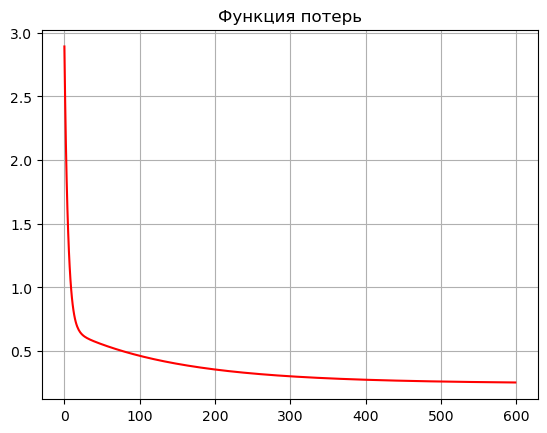

In [60]:
plt.plot(losses2, color='red')
plt.grid(True, which='both')
plt.title('Функция потерь')
plt.show()

In [61]:
x_test = torch.FloatTensor(np.array(noized_sequences))
upcoming_points_pred = predict(adaline2, x_test).numpy().flatten().tolist()

X_PRED = X[:D] + upcoming_points_pred

errors2 = [pred - true for pred, true in zip(upcoming_points_pred, upcoming_points_true)]

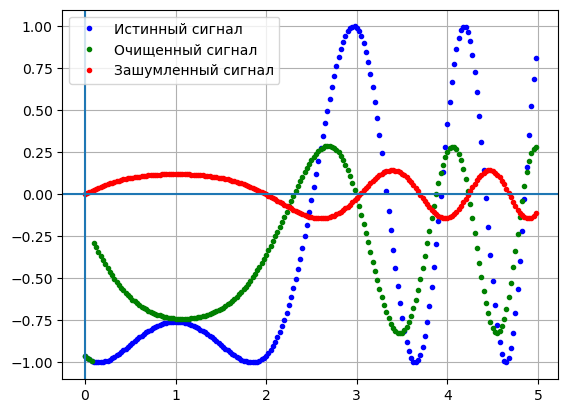

In [62]:
plt.plot(t, X, '.', color="blue", label='Истинный сигнал')
plt.plot(t, X_PRED, '.', color="green", label='Очищенный сигнал')
plt.plot(t, Y, '.', color="red", label='Зашумленный сигнал')
plt.grid(True, which='both')
plt.axhline(y=0)
plt.axvline(x=0)

plt.legend()
plt.show()

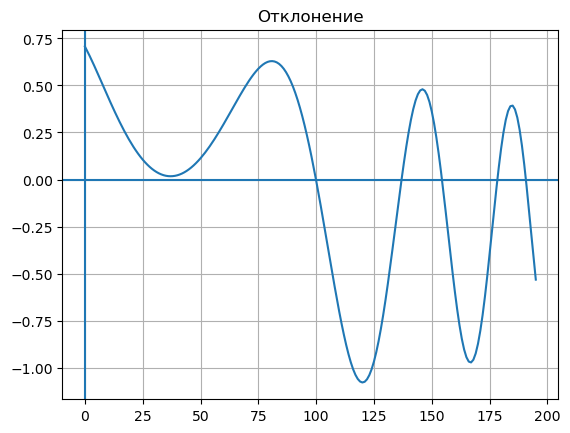

In [64]:
plt.plot(errors2)
plt.grid(True, which='both')
plt.axhline(y=0)
plt.axvline(x=0)
plt.title('Отклонение')

plt.show()

Как видно, результат при зашумлении несколько хуже, но при этом последовательность отклонений сходится, а значит, нейросеть способна подавлять помехи в сигнале. Также в данной работе была реализована модель для аппроксимации функции.